# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [1]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [1]:
import os
print("Files in current directory:")
print(os.listdir('.'))

# Check if data.zip was uploaded as a dataset or file
print("\nChecking for data files:")
if os.path.exists('data.zip'):
    print("data.zip found in current directory")
elif os.path.exists('/kaggle/input'):
    print("Input directory contents:")
    print(os.listdir('/kaggle/input'))

print("Contents of waste-data directory:")
waste_data_path = '/kaggle/input/waste-data'
print(os.listdir(waste_data_path))

# Check if there's a data.zip or direct folders
for item in os.listdir(waste_data_path):
    item_path = os.path.join(waste_data_path, item)
    print(f"{item} -> {'Directory' if os.path.isdir(item_path) else 'File'}")

Files in current directory:
['.virtual_documents']

Checking for data files:
Input directory contents:
['waste-data']
Contents of waste-data directory:
['data']
data -> Directory


In [2]:
## Import essential libraries

import tensorflow as tf
import os
# Import essential libraries

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D , Conv2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import zipfile, os

2025-07-16 06:08:07.615985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752646087.793699      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752646087.850624      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Load the dataset.

In [3]:
# Ensuring all the gpu's for memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')
# GPU is available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
len(tf.config.list_physical_devices('GPU'))
# 1 GPU is available

1

In [6]:
# Load and unzip the dataset

''' # If using google colab and data.zip is uploaded in google drive, then use below-

from google.colab import drive
drive.mount('/content/drive')

import os
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/'))

import zipfile
import os
# Extracting the dataset

zip_path = '/content/drive/MyDrive/Colab Notebooks/data.zip'
extract_path = 'data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)
'''

data_dir = '/kaggle/input/waste-data/data'
category_folders = os.listdir(data_dir)
print(f'Number of categories are : {len(category_folders)}')
print(f'Different categories are -> {category_folders}')

Number of categories are : 7
Different categories are -> ['Metal', 'Glass', 'Other', 'Paper', 'Food_Waste', 'Cardboard', 'Plastic']


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [7]:
# Create a function to load the raw images

def load_images(data_dir,  image_size=(128, 128)):
  images = []
  labels = []
  class_names = sorted(os.listdir(data_dir)) # list the directories in data_dir path
  class_to_index = {class_name: idx for idx, class_name in enumerate(class_names)}

  for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
      continue

    for img_name in os.listdir(class_path):
      img_path = os.path.join(class_path, img_name)

      try:
        with Image.open(img_path) as img: # opens the image safely using PIL.
          img = img.convert('RGB') # standardize the image
          img = img.resize(image_size) # ensuring the consistent size of the image
          img_array = np.array(img) # convert the image to np array
          images.append(img_array)
          labels.append(class_to_index[class_name])
      except:
        print(f'Corrupted Image Encoutered: {img_path}')
# return array of processed images, matching label indices, & mapping of class idx with names
  return np.array(images), np.array(labels), class_to_index


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

In [8]:
# Get the images and their labels
images, labels, class_map = load_images(data_dir)
print("Total images loaded:", len(images))
print("Image shape:", images[0].shape)
print("Class to index mapping:", class_map)

Total images loaded: 7625
Image shape: (128, 128, 3)
Class to index mapping: {'Cardboard': 0, 'Food_Waste': 1, 'Glass': 2, 'Metal': 3, 'Other': 4, 'Paper': 5, 'Plastic': 6}


<font color = green> <b> Review -1 post data loading </b> </font>
1. <b>Total images loaded:</b> 7625
2. <b>Image shape</b>: (128, 128, 3)
3. <b>Class to index mapping</b>: {'Cardboard': 0, 'Food_Waste': 1, 'Glass': 2, 'Metal': 3, 'Other': 4, 'Paper': 5, 'Plastic': 6}

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [9]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
len(batch)

Found 7625 files belonging to 7 classes.


I0000 00:00:1752646203.998609      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


2

<font color = green><b> Review - 2 post analysing the Images </b></font>
1. <b> Total Files : </b> 7625
2. <b> Total Classes : </b> 7

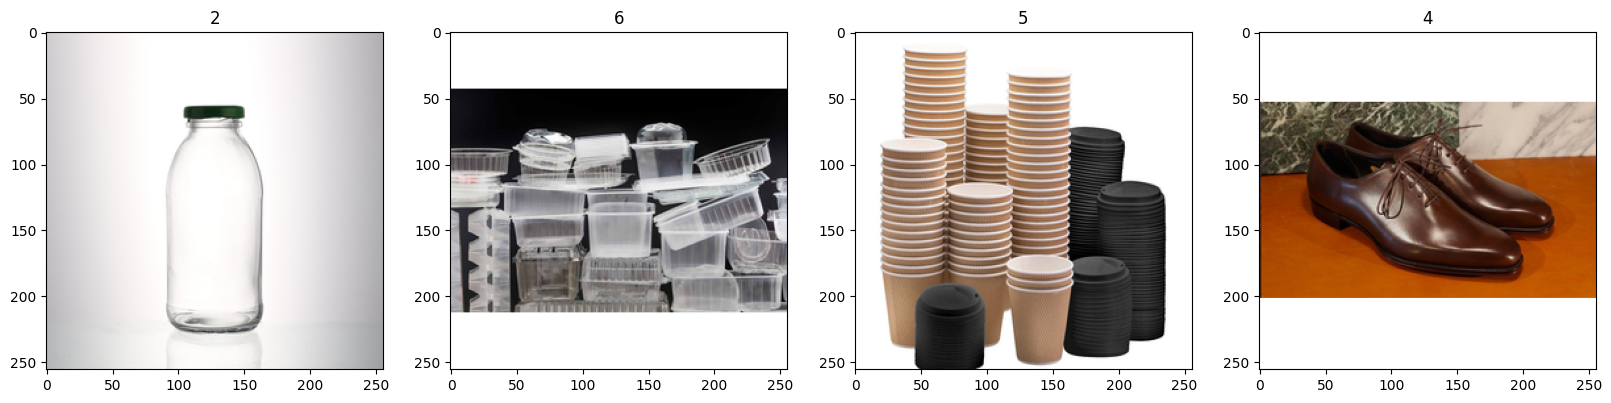

In [10]:
# Get the images and their labels

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Images are neat and clean

Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

Label Count for 0 class are : 540
Label Count for 1 class are : 1000
Label Count for 2 class are : 750
Label Count for 3 class are : 1000
Label Count for 4 class are : 1010
Label Count for 5 class are : 1030
Label Count for 6 class are : 2295


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


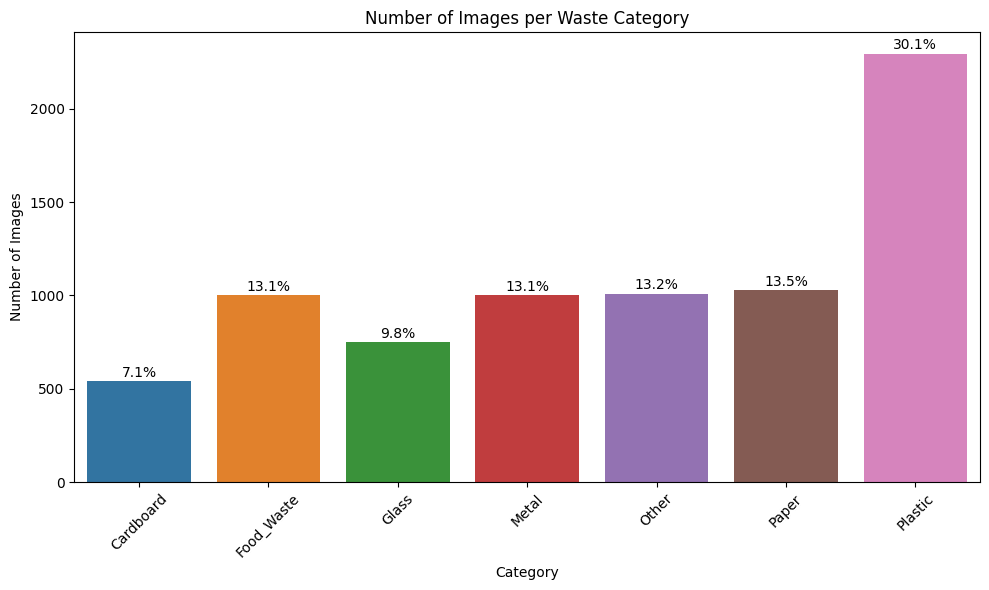

In [11]:
# Visualise Data Distribution
unique_label, label_count = np.unique(labels, return_counts=True)
for lbl, cnt in zip(unique_label,label_count):
  print(f'Label Count for {lbl} class are : {cnt}')

total_images = sum(label_count)

class_names = [list(class_map.keys())[list(class_map.values()).index(l)] for l in unique_label]
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=class_names, y=label_count)
plt.title("Number of Images per Waste Category")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
for i, count in enumerate(label_count):
    percent = f"{(count / total_images * 100):.1f}%"
    ax.text(i, count + max(label_count)*0.01, percent, ha='center', fontsize=10, color='black')
plt.show()

<font color = green><b> Review - 3 Class Imabalnce </b><font>
1. <b> Label Count for 0 (Cardboard) class are : </b> 540 (7.1%)
2. <b> Label Count for 1(Food Waste) class are : </b> 1000 (13.1%)
3. <b> Label Count for 2(Glass) class are : </b> 750 (9.8%)
4. <b> Label Count for 3(Metal) class are : </b> 1000 (13.1%)
5. <b> Label Count for 4(Other) class are : </b> 1010 (13.2%)
6. <b> Label Count for 5(Paper) class are : </b> 1030 (13.5%)
7. <b> Label Count for 6(Plastic) class are : </b> 2295 (30.1%)


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

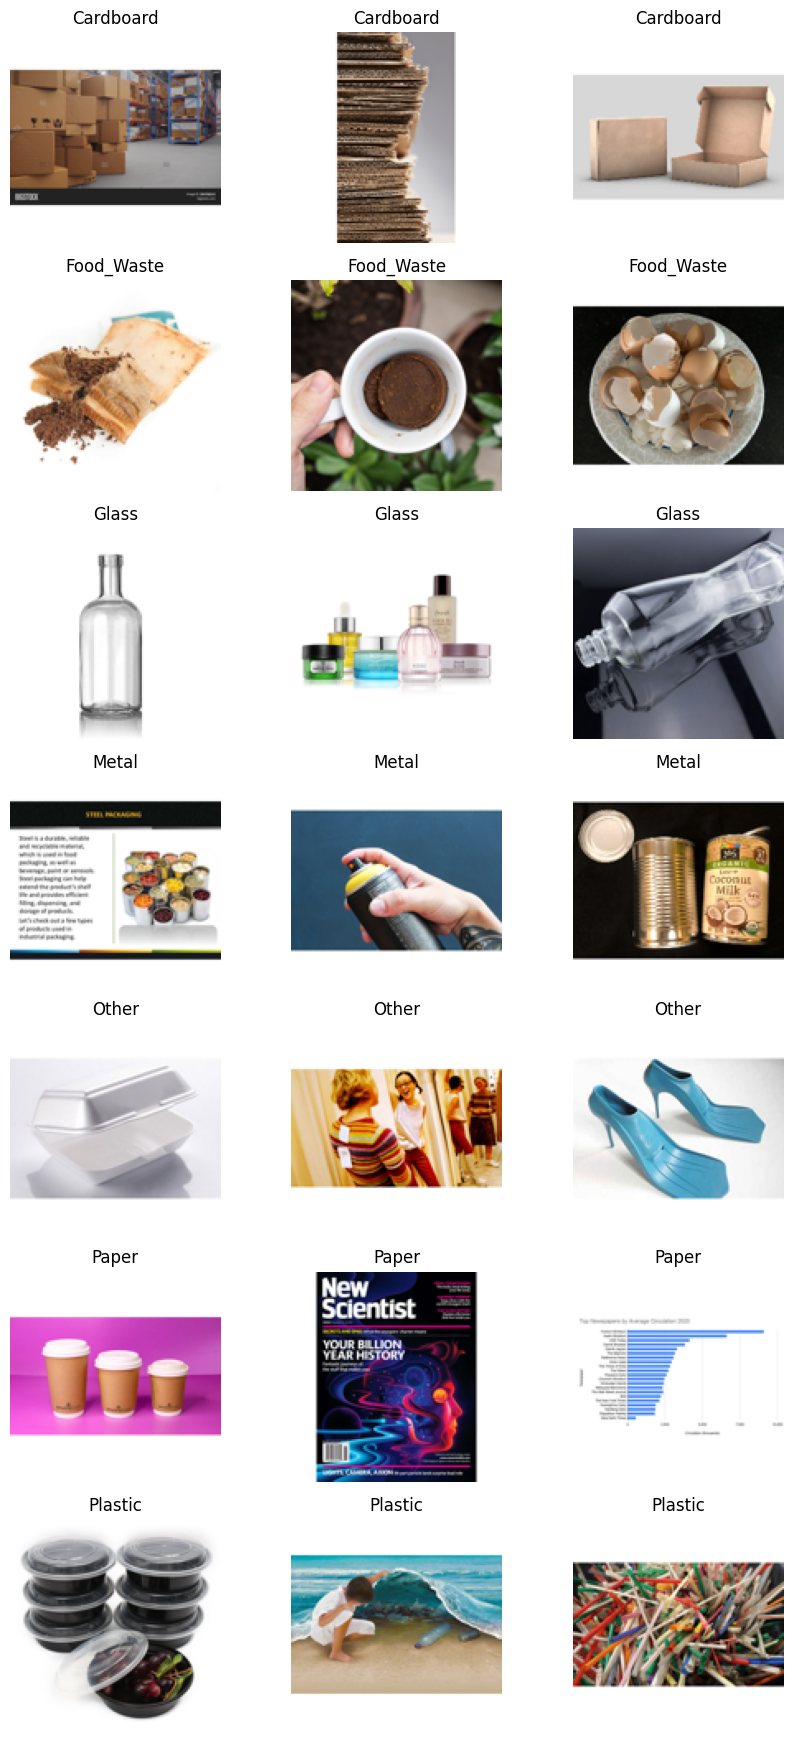

In [12]:
# Visualise Sample Images (across different labels)

def visualize_samples_per_class(images, labels, class_map, samples_per_class=3):
    class_to_index = {v: k for k, v in class_map.items()}  # Reversing the mapping

    num_classes = len(class_map)
    plt.figure(figsize=(samples_per_class * 3, num_classes * 2.5))

    for class_idx in range(num_classes):
        class_name = class_to_index[class_idx]
        class_indices = np.where(labels == class_idx)[0]

        for i in range(samples_per_class):
            img_idx = class_indices[i]
            plt_idx = class_idx * samples_per_class + i + 1

            plt.subplot(num_classes, samples_per_class, plt_idx)
            plt.imshow(images[img_idx])
            plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples_per_class(images, labels, class_map, samples_per_class=3)

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [13]:
# Find the smallest and largest image dimensions from the data set

def find_min_max_image_sizes(data_dir):
    min_width, min_height = float('inf'), float('inf')
    max_width, max_height = 0, 0

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    if width < min_width: min_width = width
                    if height < min_height: min_height = height
                    if width > max_width: max_width = width
                    if height > max_height: max_height = height
            except:
                print(f"Skipping unreadable image: {img_path}")

    print(f"Smallest image size: {min_width} x {min_height}")
    print(f"Largest image size: {max_width} x {max_height}")
find_min_max_image_sizes(data_dir)

Smallest image size: 256 x 256
Largest image size: 256 x 256


In [14]:
# Resize the image dimensions

print(f'Original dtype for images is - {images.dtype}')
print(f'Maxmimum and Minimum value of the images are {images.max()} and {images.min()}')

images = images.astype('float32') / 255.0

print(f'Converted dtype for images is - {images.dtype}')
print(f'Maxmimum and Minimum value of the images are {images.max()} and {images.min()}')

Original dtype for images is - uint8
Maxmimum and Minimum value of the images are 255 and 0
Converted dtype for images is - float32
Maxmimum and Minimum value of the images are 1.0 and 0.0


<font color = green > <b> Review - 4 Data Type</b></font>
1. Smallest image size: 256 x 256
2. Largest image size: 256 x 256
3. Original dtype for images is - uint8
4. Maxmimum and Minimum value of the images are 255 and 0
5. Converted dtype for images is - float32
6. Maxmimum and Minimum value of the images are 1.0 and 0.0

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

#### **2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [15]:
# Encode the labels suitably

num_classes = len(class_map)
label_categorical = to_categorical(labels, num_classes)

print(f'Original Lables {labels}')
print(f'One hot encoded binary vectors for the labels - {label_categorical}')
print(f'Shape of the binary vectors - {label_categorical.shape}')

Original Lables [0 0 0 ... 6 6 6]
One hot encoded binary vectors for the labels - [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Shape of the binary vectors - (7625, 7)


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [16]:
# Assign specified parts of the dataset to train and validation sets

'''
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)
'''
X_train, X_temp, y_train, y_temp = train_test_split(
    images, label_categorical, 
    test_size=0.3, 
    random_state=42, 
    stratify=labels  # Maintains class distribution
)

# Second split: Split the 30% into 20% val and 10% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.33,  # 0.33 of 30% = ~10% of total
    random_state=42,
    stratify=y_temp.argmax(axis=1)  # Use original labels for stratification
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (5337, 128, 128, 3) (5337, 7)
Validation set shape: (1532, 128, 128, 3) (1532, 7)
Test set shape: (756, 128, 128, 3) (756, 7)


<font color = green> <b> Review 5 - Data Split and Shape </b> </font>

1. Training set shape: (5337, 128, 128, 3) (5337, 7)
2. Validation set shape: (1532, 128, 128, 3) (1532, 7)
3. Test set shape: (756, 128, 128, 3) (756, 7)

## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [54]:
# Build and compile the model
model = Sequential([
    # 1st Convolution Unit / Block
    Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.2),

    # 2nd Convolution Unit / Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.3),

    #3rd Convolution Unit/Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),    
    Dropout(0.5),              
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Add another layer
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 62, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 29, 29, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,533,831 (24.92 MB)

 Trainable params: 6,533,383 (24.92 MB)

 Non-trainable params: 448 (1.75 KB)

<font color = green><b> Review-6 Sequential Model </font>
1. Total params: 6,533,831 (24.92 MB)
2. Trainable params: 6,533,383 (24.92 MB)
3. Non-trainable params: 448 (1.75 KB)

- Used Input Image shape as 128, 128, 3
- Activation Fn on CNN layers as Relu
- Activation on Dense Layers as Softmax
- Used L2 Kernel Regularization in Dense Layers
- Used BatchNormalization, MaxPooling and Dropouts.

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [17]:
# adding class weight computations as the classes are imbalanced
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights -
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)

# Convert to dictionary format that Keras expects
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class weights:", class_weight_dict)

Class weights: {0: 2.017195767195767, 1: 1.0892857142857142, 2: 1.4523809523809523, 3: 1.0892857142857142, 4: 1.0785007072135786, 5: 1.0575589459084604, 6: 0.47463429816370994}


<font color = green ><b> Review 7 Class Weights </b></font>

Since we have class Imbalance, adding ClassWeights
1. 0: 2.01719, 
2. 1: 1.08928, 
3. 2: 1.45238, 
4. 3: 1.08928, 
5. 4: 1.07850, 
6. 5: 1.05755, 
7. 6: 0.47463

In [42]:
print(f"y_train dtype: {y_train.dtype}")
print(f"y_val dtype: {y_val.dtype}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

print(f"y_train sample: {y_train[0]}")
print(f"y_val sample: {y_val[0]}")

print(f"X_train range: {X_train.min()} to {X_train.max()}")
print(f"X_val range: {X_val.min()} to {X_val.max()}")

y_train = y_train.astype('float32')
y_val = y_val.astype('float32')  # Both converted
print(f"y_train dtype: {y_train.dtype}")
print(f"y_val dtype: {y_val.dtype}")

y_train dtype: float32
y_val dtype: float32
y_train shape: (5337, 7)
y_val shape: (1532, 7)
y_train sample: [0. 0. 0. 0. 0. 0. 1.]
y_val sample: [0. 1. 0. 0. 0. 0. 0.]
X_train range: 0.0 to 1.0
X_val range: 0.0 to 1.0
y_train dtype: float32
y_val dtype: float32


In [ ]:
# After adding regularizations and Callbacks to prevent overfitting, recompiling the model

# Add callbacks to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)
checkpoint = ModelCheckpoint(
    'waste_segregation_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1,
    save_weights_only=False
)
history_baseModel = model.fit(
    X_train, y_train,
    epochs=100,
    initial_epoch=0,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr,checkpoint],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.1888 - loss: 4.7449
Epoch 1: val_loss improved from inf to 5.49871, saving model to waste_segregation_model.h5
167/167 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.1888 - loss: 4.7364 - val_accuracy: 0.0966 - val_loss: 5.4987 - learning_rate: 5.0000e-04
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.1917 - loss: 2.5083
Epoch 2: val_loss improved from 5.49871 to 4.97463, saving model to waste_segregation_model.h5
167/167 ━━━━━━━━━━━━━━━━━━━━ 30s 178ms/step - accuracy: 0.1918 - loss: 2.5082 - val_accuracy: 0.1312 - val_loss: 4.9746 - learning_rate: 5.0000e-04
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.1998 - loss: 2.4416
Epoch 3: val_loss did not improve from 4.97463
167/167 ━━━━━━━━━━━━━━━━━━━━ 30s 178ms/step - accuracy: 0.1997 - loss: 2.4416 - val_accuracy: 0.1580 - val_loss: 8.0432 - learning_rate: 5.0000e-04
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step -

In [58]:
tf.config.run_functions_eagerly(True)
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import CategoricalCrossentropy
# Or save in modern format
#model.save('waste_segregation_model.h5')  # Creates a folder with model files
best_model = load_model('waste_segregation_model.h5')

# Define checkpoint callback for continued training
checkpoint = ModelCheckpoint(
    'waste_segregation_model_continued.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
# Recompile the model with a fresh optimizer
best_model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Fresh optimizer instance
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

In [59]:
history_baseModel_continued = best_model.fit(
    X_train, y_train,
    epochs=200,
    initial_epoch=28,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr,checkpoint],
    verbose=1
)

Epoch 29/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5959 - loss: 1.7206
Epoch 29: val_loss improved from inf to 2.07232, saving model to waste_segregation_model_continued.h5
167/167 ━━━━━━━━━━━━━━━━━━━━ 31s 185ms/step - accuracy: 0.5959 - loss: 1.7206 - val_accuracy: 0.5046 - val_loss: 2.0723 - learning_rate: 5.0000e-04
Epoch 30/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6335 - loss: 1.7014
Epoch 30: val_loss improved from 2.07232 to 2.02901, saving model to waste_segregation_model_continued.h5
167/167 ━━━━━━━━━━━━━━━━━━━━ 30s 179ms/step - accuracy: 0.6334 - loss: 1.7015 - val_accuracy: 0.5470 - val_loss: 2.0290 - learning_rate: 5.0000e-04
Epoch 31/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6400 - loss: 1.7101
Epoch 31: val_loss did not improve from 2.02901
167/167 ━━━━━━━━━━━━━━━━━━━━ 29s 176ms/step - accuracy: 0.6400 - loss: 1.7103 - val_accuracy: 0.5144 - val_loss: 2.2494 - learning_rate: 5.0000e-04
Epoch 32/200
167/167 ━━━━━━━━━

<font color = green> <b> Review 8 Compiled and Fit the model </b> </font>

1. Epochs - 200
2. Callbacks - Early Stopping, Checkpoint, Reduce LR
3. ClassWeights
4. BatchSize - 32
5. Best Model converged at 179th epoch

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [63]:
# Evaluate on the test set; display suitable metrics

test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print("=== FINAL TEST RESULTS ===")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

=== FINAL TEST RESULTS ===
Test Accuracy: 0.7222
Test Loss: 1.1668


In [61]:
# Convert one-hot labels back to class indices
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(best_model.predict(X_test), axis=1)

# Classification Report

target_names = list(class_map.keys())
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Classification Report:

              precision    recall  f1-score   support

   Cardboard       0.88      0.70      0.78        54
  Food_Waste       0.72      0.82      0.76        99
       Glass       0.79      0.51      0.62        74
       Metal       0.76      0.72      0.74        99
       Other       0.69      0.63      0.66       100
       Paper       0.73      0.54      0.62       102
     Plastic       0.68      0.88      0.77       228

    accuracy                           0.72       756
   macro avg       0.75      0.69      0.71       756
weighted avg       0.73      0.72      0.72       756



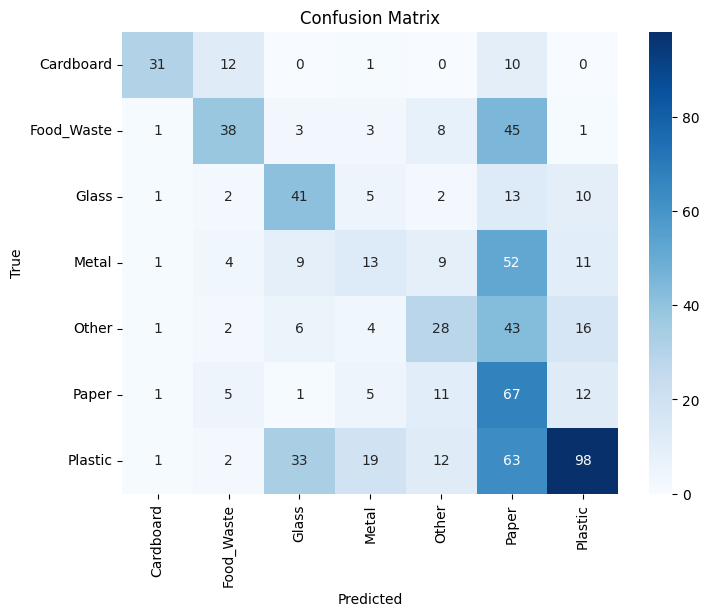

In [31]:
# Confusion Matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

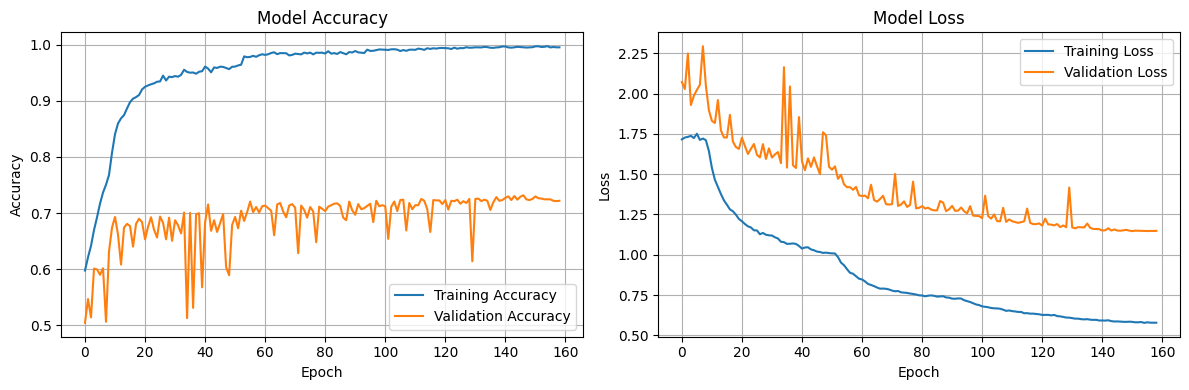

In [64]:
# Plot training history

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_baseModel_continued.history['accuracy'], label='Training Accuracy')
plt.plot(history_baseModel_continued.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_baseModel_continued.history['loss'], label='Training Loss')
plt.plot(history_baseModel_continued.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [66]:
# Per-class accuracy
from sklearn.metrics import accuracy_score

# Classification Report


print("\n=== PER-CLASS PERFORMANCE ===")
for i in range(num_classes):
    class_mask = (y_true == i)
    if np.sum(class_mask) > 0:
        class_accuracy = accuracy_score(
            y_true[class_mask], 
            y_pred[class_mask]
        )
        print(f"Class {i}: {class_accuracy:.4f} ({np.sum(class_mask)} samples)")


=== PER-CLASS PERFORMANCE ===
Class 0: 0.7037 (54 samples)
Class 1: 0.8182 (99 samples)
Class 2: 0.5135 (74 samples)
Class 3: 0.7172 (99 samples)
Class 4: 0.6300 (100 samples)
Class 5: 0.5392 (102 samples)
Class 6: 0.8772 (228 samples)


<font color = green > <b> Review 9 - Evaluation of Base Model </b> </font>

1. Test Accuracy: 0.7222 and Test Loss: 1.1668
2. Train Accuracy: 0.99 and Train Loss : 0.56
3. precision    recall  f1-score   support

   Cardboard       0.88      0.70      0.78        54
   
  Food_Waste       0.72      0.82      0.76        99

       Glass       0.79      0.51      0.62        74
       
       Metal       0.76      0.72      0.74        99
       
       Other       0.69      0.63      0.66       100
       
       Paper       0.73      0.54      0.62       102
       
     Plastic       0.68      0.88      0.77       228

4. Signs of major overfitting.
5. Per class Perfomance
   
Class 0: 0.7037 (54 samples)

Class 1: 0.8182 (99 samples)

Class 2: 0.5135 (74 samples)

Class 3: 0.7172 (99 samples)

Class 4: 0.6300 (100 samples)

Class 5: 0.5392 (102 samples)

Class 6: 0.8772 (228 samples)


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [32]:
# Define augmentation steps to augment images

# Build a Sequential Model
# Compile it
# Define ImageDatagenerator


Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [18]:
# Build and compile the model
model = Sequential([
    # 1st Convolution Unit / Block
    Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.2),

    # 2nd Convolution Unit / Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.3),

    #3rd Convolution Unit/Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),    
    Dropout(0.5),              
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Add another layer
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 29, 29, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,533,831 (24.92 MB)

 Trainable params: 6,533,383 (24.92 MB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
# Before Starting with augmentation, lets validate the types and scaling
# Convert to uint8 for ImageDataGenerator
X_train_uint8 = (X_train * 255).astype(np.uint8)
X_val_uint8 = (X_val * 255).astype(np.uint8)

In [20]:

# Labels as float32 (correct)
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')

y_train.dtype, y_val.dtype, X_train_uint8.dtype,X_val_uint8.dtype 


(dtype('float32'), dtype('float32'), dtype('uint8'), dtype('uint8'))

In [22]:
# Create a function to augment the images

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=5,
    width_shift_range=0.02,
    height_shift_range=0.02,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [23]:
# Create the augmented training dataset

validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(
    X_train_uint8, y_train,
    batch_size=32,
    shuffle=True
)
# Testing data generator
val_generator = validation_datagen.flow(
    X_val_uint8, y_val,
    batch_size=32,
    shuffle=False
)


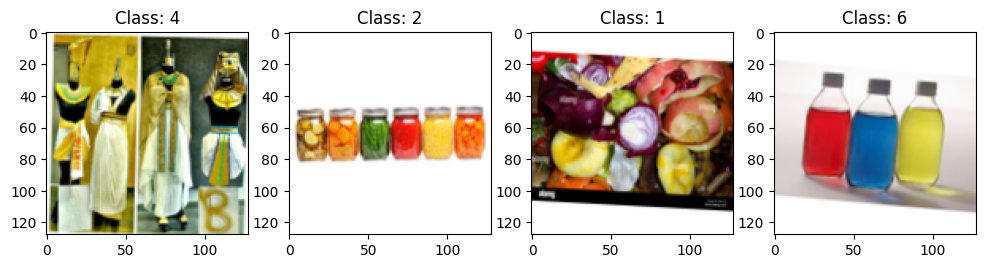

In [24]:
# Validating the sample of the augmented Images now
batch_x, batch_y = next(train_generator)
plt.figure(figsize=(12, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(batch_x[i])
    plt.title(f'Class: {np.argmax(batch_y[i])}')
plt.show()

#Loading as expected

##### **4.1.2**

Train the model on the new augmented dataset.

In [28]:
  # Train the model using augmented images

# Add callbacks to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)
checkpoint = ModelCheckpoint(
    'waste_segregation_model_aug.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

history_augmented = model.fit(
    train_generator,
    epochs=100,
    initial_epoch=0,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks = [early_stopping, reduce_lr,checkpoint],
    verbose=1
)


Epoch 1/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.3195 - loss: 1.9781
Epoch 1: val_loss improved from inf to 1.97701, saving model to waste_segregation_model_aug.h5
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.3196 - loss: 1.9781 - val_accuracy: 0.3910 - val_loss: 1.9770 - learning_rate: 2.5000e-04
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.3503 - loss: 1.9492
Epoch 2: val_loss improved from 1.97701 to 1.95876, saving model to waste_segregation_model_aug.h5
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.3502 - loss: 1.9492 - val_accuracy: 0.4269 - val_loss: 1.9588 - learning_rate: 2.5000e-04
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3395 - loss: 1.9375
Epoch 3: val_loss improved from 1.95876 to 1.87355, saving model to waste_segregation_model_aug.h5
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.3396 - loss: 1.9373 - val_accuracy: 0.4236 - val_loss: 1.8736 - learning_rate: 2.5000e-0

In [29]:
from tensorflow.keras.models import load_model
model_2 = load_model('waste_segregation_model_aug.h5')

# Define checkpoint callback for continued training
checkpoint = ModelCheckpoint(
    'waste_segregation_model_aug_continued.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
# Recompile the model with a fresh optimizer
model_2.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
train_generator = train_datagen.flow(
    X_train_uint8, y_train,
    batch_size=32,
    shuffle=True
)
val_generator = validation_datagen.flow(
    X_val_uint8, y_val,
    batch_size=32,
    shuffle=False
)
history_aug_2 = model_2.fit(
    train_generator,  # Use augmented data
    epochs=100,
    initial_epoch=35,  # Match your actual stopping epoch
    validation_data=val_generator,  # Use validation generator
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 36/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5753 - loss: 1.4892
Epoch 36: val_loss improved from inf to 1.85793, saving model to waste_segregation_model_aug_continued.h5
167/167 ━━━━━━━━━━━━━━━━━━━━ 31s 133ms/step - accuracy: 0.5752 - loss: 1.4896 - val_accuracy: 0.5352 - val_loss: 1.8579 - learning_rate: 5.0000e-04
Epoch 37/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5721 - loss: 1.5861
Epoch 37: val_loss did not improve from 1.85793
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.5720 - loss: 1.5863 - val_accuracy: 0.5248 - val_loss: 2.0088 - learning_rate: 5.0000e-04
Epoch 38/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5831 - loss: 1.6308
Epoch 38: val_loss did not improve from 1.85793
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.5830 - loss: 1.6310 - val_accuracy: 0.3779 - val_loss: 2.7807 - learning_rate: 5.0000e-04
Epoch 39/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5868 - loss: 1

In [31]:
from tensorflow.keras.models import load_model
model_3 = load_model('waste_segregation_model_aug_continued.h5')

# Define checkpoint callback for continued training
checkpoint = ModelCheckpoint(
    'waste_segregation_model_aug_continued_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
# Recompile the model with a fresh optimizer
model_3.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
train_generator = train_datagen.flow(
    X_train_uint8, y_train,
    batch_size=32,
    shuffle=True
)
val_generator = validation_datagen.flow(
    X_val_uint8, y_val,
    batch_size=32,
    shuffle=False
)
history_aug_3 = model_3.fit(
    train_generator,  # Use augmented data
    epochs=100,
    initial_epoch=58,  # Match your actual stopping epoch
    validation_data=val_generator,  # Use validation generator
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 59/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6949 - loss: 1.3738
Epoch 59: val_loss improved from inf to 2.74106, saving model to waste_segregation_model_aug_continued_2.h5
167/167 ━━━━━━━━━━━━━━━━━━━━ 30s 132ms/step - accuracy: 0.6947 - loss: 1.3744 - val_accuracy: 0.4634 - val_loss: 2.7411 - learning_rate: 5.0000e-04
Epoch 60/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6584 - loss: 1.5381
Epoch 60: val_loss improved from 2.74106 to 2.53446, saving model to waste_segregation_model_aug_continued_2.h5
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.6584 - loss: 1.5385 - val_accuracy: 0.4993 - val_loss: 2.5345 - learning_rate: 5.0000e-04
Epoch 61/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6649 - loss: 1.6209
Epoch 61: val_loss improved from 2.53446 to 2.22238, saving model to waste_segregation_model_aug_continued_2.h5
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.6649 - loss: 1.6209 - val_accuracy: 0.5979 - 

In [32]:
from tensorflow.keras.models import load_model
model_4 = load_model('waste_segregation_model_aug_continued_2.h5')

# Define checkpoint callback for continued training
checkpoint = ModelCheckpoint(
    'waste_segregation_model_aug_continued_3.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
# Recompile the model with a fresh optimizer
model_4.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
train_generator = train_datagen.flow(
    X_train_uint8, y_train,
    batch_size=32,
    shuffle=True
)
val_generator = validation_datagen.flow(
    X_val_uint8, y_val,
    batch_size=32,
    shuffle=False
)
history_aug_4 = model_4.fit(
    train_generator,  # Use augmented data
    epochs=100,
    initial_epoch=70,  # Match your actual stopping epoch
    validation_data=val_generator,  # Use validation generator
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 71/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.6793 - loss: 1.6240
Epoch 71: val_loss improved from inf to 6.66877, saving model to waste_segregation_model_aug_continued_3.h5
167/167 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - accuracy: 0.6792 - loss: 1.6243 - val_accuracy: 0.4073 - val_loss: 6.6688 - learning_rate: 5.0000e-04
Epoch 72/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6648 - loss: 1.7108
Epoch 72: val_loss improved from 6.66877 to 2.51881, saving model to waste_segregation_model_aug_continued_3.h5
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.6647 - loss: 1.7110 - val_accuracy: 0.5242 - val_loss: 2.5188 - learning_rate: 5.0000e-04
Epoch 73/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6868 - loss: 1.7168
Epoch 73: val_loss did not improve from 2.51881
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.6868 - loss: 1.7171 - val_accuracy: 0.5503 - val_loss: 2.5837 - learning_rate: 5.0000e-04
Epoch 74/100
167/1

In [33]:
# Evaluate on the test set; display suitable metrics

test_loss, test_accuracy = model_4.evaluate(X_test, y_test, verbose=0)
print("=== FINAL TEST RESULTS POST DATA AUGMENTATION===")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

=== FINAL TEST RESULTS POST DATA AUGMENTATION===
Test Accuracy: 0.6918
Test Loss: 2.0413


In [34]:
# Classification Report

# Convert one-hot labels back to class indices
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model_4.predict(X_test), axis=1)

target_names = list(class_map.keys())
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Classification Report:

              precision    recall  f1-score   support

   Cardboard       0.72      0.87      0.79        54
  Food_Waste       0.73      0.79      0.76        99
       Glass       0.64      0.59      0.62        74
       Metal       0.77      0.67      0.71        99
       Other       0.60      0.58      0.59       100
       Paper       0.56      0.67      0.61       102
     Plastic       0.77      0.71      0.74       228

    accuracy                           0.69       756
   macro avg       0.68      0.70      0.69       756
weighted avg       0.70      0.69      0.69       756



<font color = green> <b> Review 10 Evaluation of Augmented Data Model</b> </font>

1. Test Accuracy: 0.6918 and Test Loss: 2.0413
2. Train accuracy: 0.8453 - loss: 1.3677
3. Converged at 88th Epoch. Will continue to run it till 100 epochs once GPUs are available, I am sure, this will perform better
4. Classification Report:

              precision    recall  f1-score   support

       Cardboard       0.72      0.87      0.79        54
   
       Food_Waste       0.73      0.79      0.76        99
  
       Glass       0.64      0.59      0.62        74
       
       Metal       0.77      0.67      0.71        99
       
       Other       0.60      0.58      0.59       100
       
       Paper       0.56      0.67      0.61       102
       
       Plastic       0.77      0.71      0.74       228

        accuracy                           0.69       756
   

6. With Data Augmentaion, Overfitting was getting controlled, I will continue this run once I have GPUs available
   

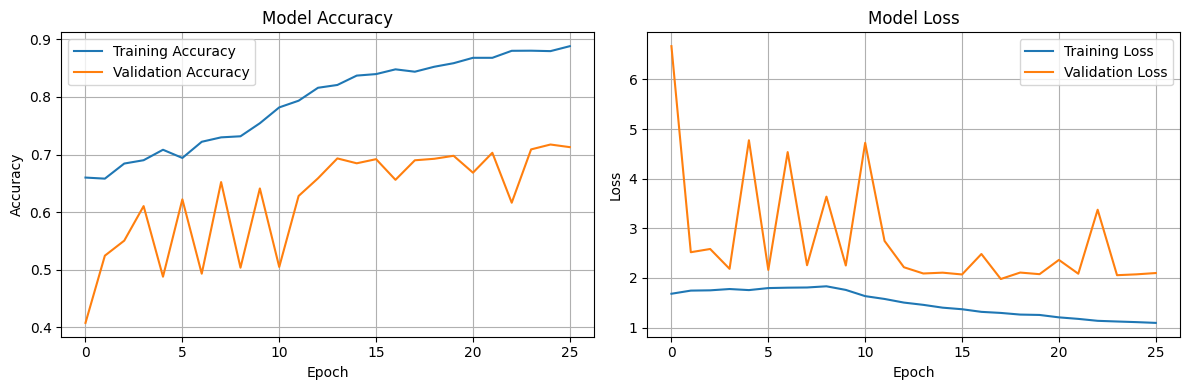

In [35]:
# Plot training history

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_aug_4.history['accuracy'], label='Training Accuracy')
plt.plot(history_aug_4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_aug_4.history['loss'], label='Training Loss')
plt.plot(history_aug_4.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

<font color = green><b> Review -1 post data loading </b> </font>

1.	Total images loaded: 7625
2.	Image shape: (128, 128, 3)
3.	Class to index mapping: {'Cardboard': 0, 'Food_Waste': 1, 'Glass': 2, 'Metal': 3, 'Other': 4, 'Paper': 5, 'Plastic': 6}


<font color = green><b> Review - 2 post analysing the Images </b> </font>

1.	Total Files : 7625
2.	Total Classes : 7
3.	Image Quality : Very neat and identifiable

<font color = green><b> Review - 3 Class Imabalnce </b> </font>

1.	Label Count for 0 (Cardboard) class are : 540 (7.1%)
2.	Label Count for 1(Food Waste) class are : 1000 (13.1%)
3.	Label Count for 2(Glass) class are : 750 (9.8%)
4.	Label Count for 3(Metal) class are : 1000 (13.1%)
5.	Label Count for 4(Other) class are : 1010 (13.2%)
6.	Label Count for 5(Paper) class are : 1030 (13.5%)
7.	Label Count for 6(Plastic) class are : 2295 (30.1%)

 <font color = green><b> Review - 4 Data Type </b> </font>
 
1.	Smallest image size: 256 x 256
2.	Largest image size: 256 x 256
3.	Original dtype for images is - uint8
4.	Maxmimum and Minimum value of the images are 255 and 0
5.	Converted dtype for images is - float32
6.	Maxmimum and Minimum value of the images are 1.0 and 0.0
We encoded the labels and Shape of the binary vectors - (7625, 7)

<font color = green><b> Review 5 - Data Split and Shape </b> </font>

1.	Training set shape: (5337, 128, 128, 3) (5337, 7)
2.	Validation set shape: (1532, 128, 128, 3) (1532, 7)
3.	Test set shape: (756, 128, 128, 3) (756, 7)

<font color = green><b> Review-6 Sequential Model </b> </font>

1.	Total params: 6,533,831 (24.92 MB)
2.	Trainable params: 6,533,383 (24.92 MB)
3.	Non-trainable params: 448 (1.75 KB)
•	Used Input Image shape as 128, 128, 3
•	Activation Fn on CNN layers as Relu
•	Activation on Dense Layers as Softmax
•	Used L2 Kernel Regularization in Dense Layers
•	Used BatchNormalization, MaxPooling and Dropouts.

 <font color = green><b> Review 7 Class Weights </b> </font>
 
Since we have class Imbalance, adding ClassWeights

1.	0: 2.01719,
2.	1: 1.08928,
3.	2: 1.45238,
4.	3: 1.08928,
5.	4: 1.07850,
6.	5: 1.05755,
7.	6: 0.47463


<font color = green><b> Review 8 Compiled and Fit the model </b> </font>

1.	Epochs - 100
2.	Callbacks - Early Stopping, Checkpoint, Reduce LR
3.	ClassWeights
4.	BatchSize - 32

<font color = green><b> Review 9 - Evaluation of Base Model </b> </font>

1.	Test Accuracy: 0.7222 and Test Loss: 1.1668
2.	Train Accuracy: 0.99 and Train Loss : 0.56
3.
| Class        | Precision | Recall | F1-Score | Support |
|--------------|-----------|--------|----------|---------|
| Cardboard    | 0.88      | 0.70   | 0.78     | 54      |
| Food_Waste   | 0.72      | 0.82   | 0.76     | 99      |
| Glass        | 0.79      | 0.51   | 0.62     | 74      |
| Metal        | 0.76      | 0.72   | 0.74     | 99      |
| Other        | 0.69      | 0.63   | 0.66     | 100     |
| Paper        | 0.73      | 0.54   | 0.62     | 102     |
| Plastic      | 0.68      | 0.88   | 0.77     | 228     |
| accuracy     |           |    |        **0.72**  |         |


5.	Signs of major overfitting.
6.	Per class Perfomance

| Class Label | Class Name  | Recall  | Support |
|-------------|-------------|---------|---------|
| 0           | Cardboard   | 0.7037  | 54      |
| 1           | Food_Waste  | 0.8182  | 99      |
| 2           | Glass       | 0.5135  | 74      |
| 3           | Metal       | 0.7172  | 99      |
| 4           | Other       | 0.6300  | 100     |
| 5           | Paper       | 0.5392  | 102     |
| 6           | Plastic     | 0.8772  | 228     |


<font color = green><b> Review 10 Evaluation of Augmented Data Model </b> </font>

1.	Test Accuracy: 0.6918 and Test Loss: 2.013
2.	Train accuracy: 0.7846 - loss: 1.1074
3. Data Augmentation might have converged well, with reduced overfitting.
4.	Converged at 49th Epoch. Will continue to run it till 100 epochs once GPUs are available, I am sure, this will perform better
5.	Classification Report:

| Class        | Precision | Recall | F1-Score | Support |
|--------------|-----------|--------|----------|---------|
| Cardboard    | 0.95      | 0.72   | 0.82     | 54      |
| Food_Waste   | 0.64      | 0.86   | 0.73     | 99      |
| Glass        | 0.77      | 0.49   | 0.60     | 74      |
| Metal        | 0.66      | 0.68   | 0.67     | 99      |
| Other        | 0.65      | 0.45   | 0.53     | 100     |
| Paper        | 0.45      | 0.66   | 0.54     | 102     |
| Plastic      | 0.73      | 0.69   | 0.71     | 228     |
| **Overall Accuracy** |        |   | **0.6918** | 756     |


5.=== PER-CLASS PERFORMANCE ===
| Class Label | Class Name  | Recall  | Support |
|-------------|-------------|---------|---------|
| 0           | Cardboard   | 0.8704  | 54      |
| 1           | Food_Waste  | 0.7879  | 99      |
| 2           | Glass       | 0.5946  | 74      |
| 3           | Metal       | 0.6667  | 99      |
| 4           | Other       | 0.5800  | 100     |
| 5           | Paper       | 0.6667  | 102     |
| 6           | Plastic     | 0.7105  | 228     |


6.With Data Augmentaion, Overfitting was getting controlled, I will continue this run once I have GPUs available



### Areas of Concern

#### Significant Overfitting:

Base model shows severe overfitting (99% train accuracy vs 72% test accuracy)
Large gap between train and test performance indicates the model memorized training data

#### Class Imbalance Issues:

Plastic class dominates with 30.1% of data vs Cardboard with only 7.1%
This imbalance affects model performance despite class weights

#### Inconsistent Results:

Data augmentation model shows lower overall accuracy (65.74% vs 72.22%)
Some classes improved while others degraded with augmentation

#### Recommendations:

Collect more samples for Glass & Paper class as Cardboard (7.1%) and Glass (9.8%) are severely underrepresented compared to Plastic (30.1%)

Paper and Cardboard are too similar, causing confusion may be thus performed poorly

The "Other" class lacks coherent visual patterns

Using DenseNet121 (Parameters: ~8M  , Depth: 121 layers, Memory: Moderate) might have worked well. We can expect like 80-85 % accuracy on validation data